# Linear Mixed Effects Models

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

**Note**: The R code and the results in this notebook has been converted to markdown so that R is not required to build the documents. The R results in the notebook were computed using R 3.5.1 and lme4 1.1.

```ipython
%load_ext rpy2.ipython
```

```ipython
%R library(lme4)
```

```
array(['lme4', 'Matrix', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], dtype='<U9')
```

Comparing R lmer to statsmodels MixedLM
=======================================

The statsmodels implementation of linear mixed models (MixedLM) closely follows the approach outlined in Lindstrom and Bates (JASA 1988).  This is also the approach followed in the  R package LME4.  Other packages such as Stata, SAS, etc. should also be consistent with this approach, as the basic techniques in this area are mostly mature.

Here we show how linear mixed models can be fit using the MixedLM procedure in statsmodels.  Results from R (LME4) are included for comparison.

Here are our import statements:

## Growth curves of pigs

These are longitudinal data from a factorial experiment. The outcome variable is the weight of each pig, and the only predictor variable we will use here is "time".  First we fit a model that expresses the mean weight as a linear function of time, with a random intercept for each pig. The model is specified using formulas. Since the random effects structure is not specified, the default random effects structure (a random intercept for each group) is automatically used. 

In [2]:
data = sm.datasets.get_rdataset("dietox", "geepack").data
md = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Weight    
No. Observations: 861     Method:             REML      
No. Groups:       72      Scale:              11.3669   
Min. group size:  11      Log-Likelihood:     -2404.7753
Max. group size:  12      Converged:          Yes       
Mean group size:  12.0                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept    15.724    0.788  19.952 0.000 14.179 17.268
Time          6.943    0.033 207.939 0.000  6.877  7.008
Group Var    40.395    2.149                            



Here is the same model fit in R using LMER:

```ipython
%%R
data(dietox, package='geepack')
```

```ipython
%R print(summary(lmer('Weight ~ Time + (1|Pig)', data=dietox)))
```

```
Linear mixed model fit by REML ['lmerMod']
Formula: Weight ~ Time + (1 | Pig)
   Data: dietox

REML criterion at convergence: 4809.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.7118 -0.5696 -0.0943  0.4877  4.7732 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pig      (Intercept) 40.39    6.356   
 Residual             11.37    3.371   
Number of obs: 861, groups:  Pig, 72

Fixed effects:
            Estimate Std. Error t value
(Intercept) 15.72352    0.78805   19.95
Time         6.94251    0.03339  207.94

Correlation of Fixed Effects:
     (Intr)
Time -0.275
```

Note that in the statsmodels summary of results, the fixed effects and random effects parameter estimates are shown in a single table.  The random effect for animal is labeled "Intercept RE" in the statsmodels output above.  In the LME4 output, this effect is the pig intercept under the random effects section.

There has been a lot of debate about whether the standard errors for random effect variance and covariance parameters are useful.  In LME4, these standard errors are not displayed, because the authors of the package believe they are not very informative.  While there is good reason to question their utility, we elected to include the standard errors in the summary table, but do not show the corresponding Wald confidence intervals.

Next we fit a model with two random effects for each animal: a random intercept, and a random slope (with respect to time).  This means that each pig may have a different baseline weight, as well as growing at a different rate. The formula specifies that "Time" is a covariate with a random coefficient.  By default, formulas always include an intercept (which could be suppressed here using "0 + Time" as the formula).

In [3]:
md = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"], re_formula="~Time")
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Weight    
No. Observations:  861      Method:              REML      
No. Groups:        72       Scale:               6.0372    
Min. group size:   11       Log-Likelihood:      -2217.0475
Max. group size:   12       Converged:           Yes       
Mean group size:   12.0                                    
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        15.739    0.550 28.603 0.000 14.660 16.817
Time              6.939    0.080 86.925 0.000  6.783  7.095
Group Var        19.503    1.561                           
Group x Time Cov  0.294    0.153                           
Time Var          0.416    0.033                           



Here is the same model fit using LMER in R:

```ipython
%R print(summary(lmer("Weight ~ Time + (1 + Time | Pig)", data=dietox)))
```

```
Linear mixed model fit by REML ['lmerMod']
Formula: Weight ~ Time + (1 + Time | Pig)
   Data: dietox

REML criterion at convergence: 4434.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.4286 -0.5529 -0.0416  0.4841  3.5624 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 Pig      (Intercept) 19.493   4.415        
          Time         0.416   0.645    0.10
 Residual              6.038   2.457        
Number of obs: 861, groups:  Pig, 72

Fixed effects:
            Estimate Std. Error t value
(Intercept) 15.73865    0.55012   28.61
Time         6.93901    0.07982   86.93

Correlation of Fixed Effects:
     (Intr)
Time 0.006 
```

The random intercept and random slope are only weakly correlated $(0.294 / \sqrt{19.493 * 0.416} \approx 0.1)$.  So next we fit a model in which the two random effects are constrained to be uncorrelated:

In [4]:
0.294 / (19.493 * 0.416) ** 0.5

0.10324316832591753

In [5]:
md = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"], re_formula="~Time")
free = sm.regression.mixed_linear_model.MixedLMParams.from_components(
    np.ones(2), np.eye(2)
)

mdf = md.fit(free=free, method=["lbfgs"])
print(mdf.summary())

           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Weight    
No. Observations:  861      Method:              REML      
No. Groups:        72       Scale:               6.0283    
Min. group size:   11       Log-Likelihood:      -2217.3481
Max. group size:   12       Converged:           Yes       
Mean group size:   12.0                                    
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        15.739    0.554 28.388 0.000 14.652 16.825
Time              6.939    0.080 86.248 0.000  6.781  7.097
Group Var        19.837    1.571                           
Group x Time Cov  0.000    0.000                           
Time Var          0.423    0.033                           



The likelihood drops by 0.3 when we fix the correlation parameter to 0.  Comparing 2 x 0.3 = 0.6 to the chi^2 1 df reference distribution suggests that the data are very consistent with a model in which this parameter is equal to 0.

Here is the same model fit using LMER in R (note that here R is reporting the REML criterion instead of the likelihood, where the REML criterion is twice the log likelihood):

```ipython
%R print(summary(lmer("Weight ~ Time + (1 | Pig) + (0 + Time | Pig)", data=dietox)))
```

```
Linear mixed model fit by REML ['lmerMod']
Formula: Weight ~ Time + (1 | Pig) + (0 + Time | Pig)
   Data: dietox

REML criterion at convergence: 4434.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.4281 -0.5527 -0.0405  0.4840  3.5661 

Random effects:
 Groups   Name        Variance Std.Dev.
 Pig      (Intercept) 19.8404  4.4543  
 Pig.1    Time         0.4234  0.6507  
 Residual              6.0282  2.4552  
Number of obs: 861, groups:  Pig, 72

Fixed effects:
            Estimate Std. Error t value
(Intercept) 15.73875    0.55444   28.39
Time         6.93899    0.08045   86.25

Correlation of Fixed Effects:
     (Intr)
Time -0.086
```


## Sitka growth data

This is one of the example data sets provided in the LMER R library.  The outcome variable is the size of the tree, and the covariate used here is a time value.  The data are grouped by tree.

In [6]:
data = sm.datasets.get_rdataset("Sitka", "MASS").data
endog = data["size"]
data["Intercept"] = 1
exog = data[["Intercept", "Time"]]

Here is the statsmodels LME fit for a basic model with a random intercept.  We are passing the endog and exog data directly to the LME init function as arrays.  Also note that endog_re is specified explicitly in argument 4 as a random intercept (although this would also be the default if it were not specified).

In [7]:
md = sm.MixedLM(endog, exog, groups=data["tree"], exog_re=exog["Intercept"])
mdf = md.fit()
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: size    
No. Observations:  395     Method:             REML    
No. Groups:        79      Scale:              0.0392  
Min. group size:   5       Log-Likelihood:     -82.3884
Max. group size:   5       Converged:          Yes     
Mean group size:   5.0                                 
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     2.273    0.088 25.864 0.000  2.101  2.446
Time          0.013    0.000 47.796 0.000  0.012  0.013
Intercept Var 0.374    0.345                           



Here is the same model fit in R using LMER:

```ipython
%R
data(Sitka, package="MASS")
print(summary(lmer("size ~ Time + (1 | tree)", data=Sitka)))
```

```
Linear mixed model fit by REML ['lmerMod']
Formula: size ~ Time + (1 | tree)
   Data: Sitka

REML criterion at convergence: 164.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9979 -0.5169  0.1576  0.5392  4.4012 

Random effects:
 Groups   Name        Variance Std.Dev.
 tree     (Intercept) 0.37451  0.612   
 Residual             0.03921  0.198   
Number of obs: 395, groups:  tree, 79

Fixed effects:
             Estimate Std. Error t value
(Intercept) 2.2732443  0.0878955   25.86
Time        0.0126855  0.0002654   47.80

Correlation of Fixed Effects:
     (Intr)
Time -0.611
```

We can now try to add a random slope.  We start with R this time.  From the code and output below we see that the REML estimate of the variance of the random slope is nearly zero.

```ipython
%R print(summary(lmer("size ~ Time + (1 + Time | tree)", data=Sitka)))
```

```
Linear mixed model fit by REML ['lmerMod']
Formula: size ~ Time + (1 + Time | tree)
   Data: Sitka

REML criterion at convergence: 153.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7609 -0.5173  0.1188  0.5270  3.5466 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr 
 tree     (Intercept) 2.217e-01 0.470842      
          Time        3.288e-06 0.001813 -0.17
 Residual             3.634e-02 0.190642      
Number of obs: 395, groups:  tree, 79

Fixed effects:
            Estimate Std. Error t value
(Intercept) 2.273244   0.074655   30.45
Time        0.012686   0.000327   38.80

Correlation of Fixed Effects:
     (Intr)
Time -0.615
convergence code: 0
Model failed to converge with max|grad| = 0.793203 (tol = 0.002, component 1)
Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?
```

If we run this in statsmodels LME with defaults, we see that the variance estimate is indeed very small, which leads to a warning about the solution being on the boundary of the parameter space.  The regression slopes agree very well with R, but the likelihood value is much higher than that returned by R.

In [8]:
exog_re = exog.copy()
md = sm.MixedLM(endog, exog, data["tree"], exog_re)
mdf = md.fit()
print(mdf.summary())

/opt/hostedtoolcache/Python/3.10.13/x64/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    size    
No. Observations:    395        Method:                REML    
No. Groups:          79         Scale:                 0.0264  
Min. group size:     5          Log-Likelihood:        -62.4834
Max. group size:     5          Converged:             Yes     
Mean group size:     5.0                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             2.273    0.101 22.513 0.000  2.075  2.471
Time                  0.013    0.000 33.888 0.000  0.012  0.013
Intercept Var         0.646    0.914                           
Intercept x Time Cov -0.001    0.003                           
Time Var              0.000    0.000                           



We can further explore the random effects structure by constructing plots of the profile likelihoods. We start with the random intercept, generating a plot of the profile likelihood from 0.1 units below to 0.1 units above the MLE. Since each optimization inside the profile likelihood generates a warning (due to the random slope variance being close to zero), we turn off the warnings here.

In [9]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    likev = mdf.profile_re(0, "re", dist_low=0.1, dist_high=0.1)

Here is a plot of the profile likelihood function.  We multiply the log-likelihood difference by 2 to obtain the usual $\chi^2$ reference distribution with 1 degree of freedom.

In [10]:
import matplotlib.pyplot as plt

Text(0, 0.5, '-2 times profile log likelihood')

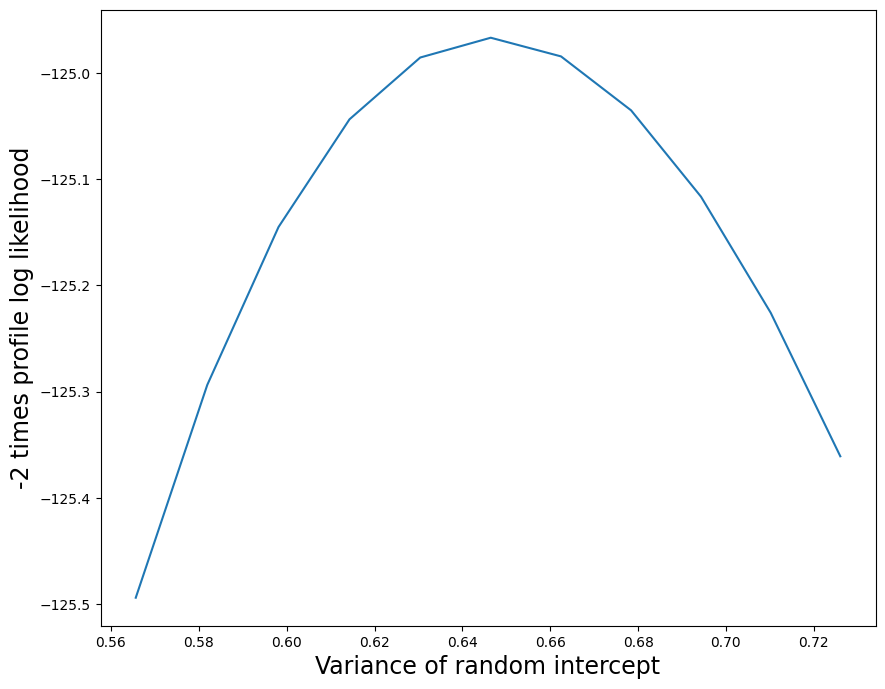

In [11]:
plt.figure(figsize=(10, 8))
plt.plot(likev[:, 0], 2 * likev[:, 1])
plt.xlabel("Variance of random intercept", size=17)
plt.ylabel("-2 times profile log likelihood", size=17)

Here is a plot of the profile likelihood function. The profile likelihood plot shows that the MLE of the random slope variance parameter is a very small positive number, and that there is low uncertainty in this estimate.

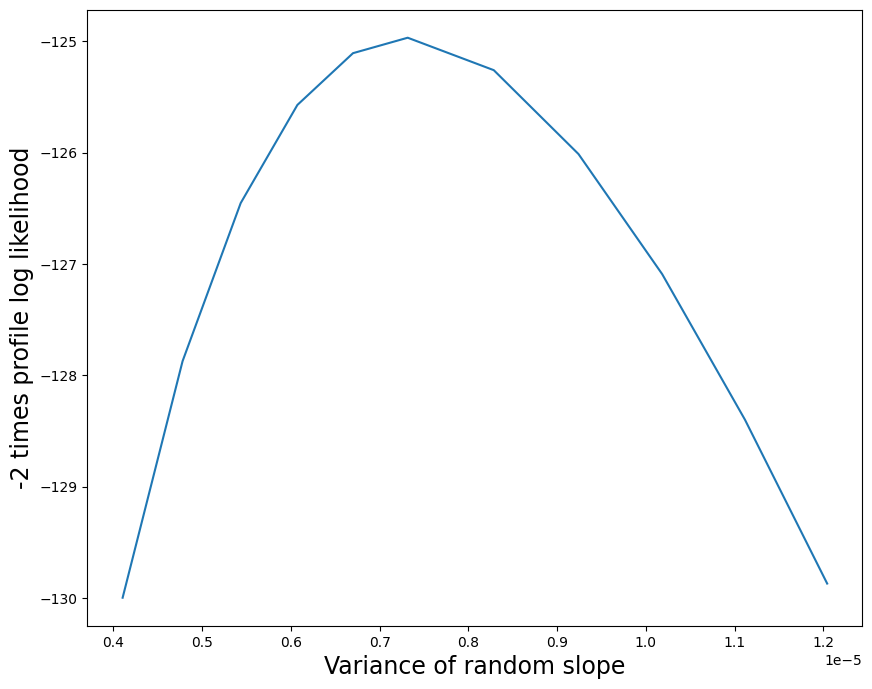

In [12]:
re = mdf.cov_re.iloc[1, 1]
with warnings.catch_warnings():
    # Parameter is often on the boundary
    warnings.simplefilter("ignore", ConvergenceWarning)
    likev = mdf.profile_re(1, "re", dist_low=0.5 * re, dist_high=0.8 * re)

plt.figure(figsize=(10, 8))
plt.plot(likev[:, 0], 2 * likev[:, 1])
plt.xlabel("Variance of random slope", size=17)
lbl = plt.ylabel("-2 times profile log likelihood", size=17)